In [ ]:
import cv2

print('loaded..')
# Read the image
image = cv2.imread(r'D:\OneDrive - NITT\Desktop\New folder\CountingInput_2024-02-02-054519-min.jpg')  # Replace 'your_image_path.jpg' with the path to your image

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Detect circles using Hough Circle Transform
circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=0)

# Convert the circles to integers
circles = circles.round().astype("int")

# Initialize a counter for the number of circles
num_circles = 0

# Draw the detected circles
if circles is not None:
    for (x, y, r) in circles[0]:
        print('*')
        # Draw the circle
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        # Increment the circle counter
        num_circles += 1

# Display the image with detected circles
cv2.imshow("Image with Circles", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print the number of circles detected
print("Number of circles:", num_circles)


In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread(r'D:\OneDrive - NITT\Desktop\New folder\CountingInput_2024-02-02-054519-min.jpg')  # Replace 'your_image_path.jpg' with the path to your image

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
# Parameters for the Hough Circle Transform
circles = cv2.HoughCircles(
    blurred_image,
    cv2.HOUGH_GRADIENT,
    dp=1,  # Inverse ratio of the accumulator resolution to the image resolution
    minDist=50,  # Minimum distance between detected centers
    param1=100,  # Upper threshold for the internal Canny edge detector
    param2=30,   # Threshold for center detection
    minRadius=10,  # Minimum radius to be detected
    maxRadius=100  # Maximum radius to be detected
)
if circles is not None:
    num_circles = len(circles[0])
    print(f'Number of circles: {num_circles}')
else:
    print('No circles detected.')
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw the outer circle
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

    # Display the image with detected circles
    cv2.imshow('Detected Circles', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
import cv2

path = r'D:\OneDrive - NITT\Desktop\New folder\CountingInput_2024-02-02-054519-min.jpg'
# Define color ranges for lids
grey_min = np.array([170, 170, 170])
grey_max = np.array([255, 255, 255])
orange_min = np.array([0, 100, 100])
orange_max = np.array([40, 255, 255])
green_min = np.array([40, 100, 100])
green_max = np.array([80, 255, 255])

# Load the image
image = cv2.imread(path)

# Convert the image to HSV color space for better color detection
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create masks for each color
grey_mask = cv2.inRange(hsv_image, grey_min, grey_max)
orange_mask = cv2.inRange(hsv_image, orange_min, orange_max)
green_mask = cv2.inRange(hsv_image, green_min, green_max)

# Combine the masks for all colors
mask = grey_mask | orange_mask | green_mask

# Apply morphological operations to reduce noise and improve detection
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Find contours of the tubes
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Count the number of tubes
number_of_tubes = len(contours)

# Print the number of tubes
print("Number of tubes:", number_of_tubes)

# (Optional) Draw the contours on the image for visualization
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
cv2.imshow("Image with contours", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

img = cv2.imread(path)
mask = cv2.threshold(img[:, :, 0], 255, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

stats = cv2.connectedComponentsWithStats(mask, 8)[2]
label_area = stats[1:, cv2.CC_STAT_AREA]

min_area, max_area = 50, 350  # min/max for a single circle
singular_mask = (min_area < label_area) & (label_area <= max_area)
circle_area = np.mean(label_area[singular_mask])

n_circles = int(np.sum(np.round(label_area / circle_area)))

print('Total circles:', n_circles)

In [ ]:
from math import sqrt, atan2, pi
import numpy as np

def canny_edge_detector(input_image):
    input_pixels = input_image.load()
    width = input_image.width
    height = input_image.height

    # Transform the image to grayscale
    grayscaled = compute_grayscale(input_pixels, width, height)

    # Blur it to remove noise
    blurred = compute_blur(grayscaled, width, height)

    # Compute the gradient
    gradient, direction = compute_gradient(blurred, width, height)

    # Non-maximum suppression
    filter_out_non_maximum(gradient, direction, width, height)

    # Filter out some edges
    keep = filter_strong_edges(gradient, width, height, 20, 25)

    return keep


def compute_grayscale(input_pixels, width, height):
    grayscale = np.empty((width, height))
    for x in range(width):
        for y in range(height):
            pixel = input_pixels[x, y]
            grayscale[x, y] = (pixel[0] + pixel[1] + pixel[2]) / 3
    return grayscale


def compute_blur(input_pixels, width, height):
    # Keep coordinate inside image
    clip = lambda x, l, u: l if x < l else u if x > u else x

    # Gaussian kernel
    kernel = np.array([
        [1 / 256,  4 / 256,  6 / 256,  4 / 256, 1 / 256],
        [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
        [6 / 256, 24 / 256, 36 / 256, 24 / 256, 6 / 256],
        [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
        [1 / 256,  4 / 256,  6 / 256,  4 / 256, 1 / 256]
    ])

    # Middle of the kernel
    offset = len(kernel) // 2

    # Compute the blurred image
    blurred = np.empty((width, height))
    for x in range(width):
        for y in range(height):
            acc = 0
            for a in range(len(kernel)):
                for b in range(len(kernel)):
                    xn = clip(x + a - offset, 0, width - 1)
                    yn = clip(y + b - offset, 0, height - 1)
                    acc += input_pixels[xn, yn] * kernel[a, b]
            blurred[x, y] = int(acc)
    return blurred


def compute_gradient(input_pixels, width, height):
    gradient = np.zeros((width, height))
    direction = np.zeros((width, height))
    for x in range(width):
        for y in range(height):
            if 0 < x < width - 1 and 0 < y < height - 1:
                magx = input_pixels[x + 1, y] - input_pixels[x - 1, y]
                magy = input_pixels[x, y + 1] - input_pixels[x, y - 1]
                gradient[x, y] = sqrt(magx**2 + magy**2)
                direction[x, y] = atan2(magy, magx)
    return gradient, direction


def filter_out_non_maximum(gradient, direction, width, height):
    for x in range(1, width - 1):
        for y in range(1, height - 1):
            angle = direction[x, y] if direction[x, y] >= 0 else direction[x, y] + pi
            rangle = round(angle / (pi / 4))
            mag = gradient[x, y]
            if ((rangle == 0 or rangle == 4) and (gradient[x - 1, y] > mag or gradient[x + 1, y] > mag)
                    or (rangle == 1 and (gradient[x - 1, y - 1] > mag or gradient[x + 1, y + 1] > mag))
                    or (rangle == 2 and (gradient[x, y - 1] > mag or gradient[x, y + 1] > mag))
                    or (rangle == 3 and (gradient[x + 1, y - 1] > mag or gradient[x - 1, y + 1] > mag))):
                gradient[x, y] = 0


def filter_strong_edges(gradient, width, height, low, high):
    # Keep strong edges
    keep = set()
    for x in range(width):
        for y in range(height):
            if gradient[x, y] > high:
                keep.add((x, y))

    # Keep weak edges next to a pixel to keep
    lastiter = keep
    while lastiter:
        newkeep = set()
        for x, y in lastiter:
            for a, b in ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)):
                if gradient[x + a, y + b] > low and (x+a, y+b) not in keep:
                    newkeep.add((x+a, y+b))
        keep.update(newkeep)
        lastiter = newkeep

    return list(keep)


# if __name__ == "__main__":
#     from PIL import Image, ImageDraw
#     input_image = Image.open("input.png")
#     output_image = Image.new("RGB", input_image.size)
#     draw = ImageDraw.Draw(output_image)
#     for x, y in canny_edge_detector(input_image):
#         draw.point((x, y), (255, 255, 255))
#     output_image.save("canny.png")

In [ ]:
from PIL import Image, ImageDraw
from math import sqrt, pi, cos, sin
# from canny import canny_edge_detector
from collections import defaultdict

# Load image:

path = r'D:\OneDrive - NITT\Desktop\New folder\CountingInput_2024-02-02-054519-min.jpg'
input_image = Image.open(path)

# Output image:
output_image = Image.new("RGB", input_image.size)
output_image.paste(input_image)
draw_result = ImageDraw.Draw(output_image)

# Find circles
rmin = 18
rmax = 20
steps = 100
threshold = 0.4

points = []
for r in range(rmin, rmax + 1):
    for t in range(steps):
        points.append((r, int(r * cos(2 * pi * t / steps)), int(r * sin(2 * pi * t / steps))))

acc = defaultdict(int)
for x, y in canny_edge_detector(input_image):
    for r, dx, dy in points:
        a = x - dx
        b = y - dy
        acc[(a, b, r)] += 1

circles = []
for k, v in sorted(acc.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v / steps >= threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
        print(v / steps, x, y, r)
        circles.append((x, y, r))

for x, y, r in circles:
    draw_result.ellipse((x-r, y-r, x+r, y+r), outline=(255,0,0,0))

# Save output image
output_image.save("result.png")
# https://www.codingame.com/playgrounds/38470/how-to-detect-circles-in-images

In [ ]:
import pandas as pd

In [ ]:
# AASCII
df = pd.read_csv(r'D:\OneDrive - NITT\Custom_Download\AASCII.csv',nrows=20)

In [ ]:
df.shape

In [ ]:
df

# stackoverflow

In [ ]:
import cv2

def draw_circles(img, circles):
    # img = cv2.imread(img,0)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    for i in circles[0,:]:
    # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.putText(cimg,str(i[0])+str(',')+str(i[1]), (i[0],i[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255)
    return cimg

def detect_circles(image_path):
    gray = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
    
    # Convert RGB image to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    gray_blur = cv2.medianBlur(gray, 13)  # Remove noise before laplacian
    gray_lap = cv2.Laplacian(gray_blur, cv2.CV_8UC1, ksize=5)
    dilate_lap = cv2.dilate(gray_lap, (3, 3))  # Fill in gaps from blurring. This helps to detect circles with broken edges.
    # Furture remove noise introduced by laplacian. This removes false pos in space between the two groups of circles.
    lap_blur = cv2.bilateralFilter(dilate_lap, 5, 9, 9)
    # Fix the resolution to 16. This helps it find more circles. Also, set distance between circles to 55 by measuring dist in image.
    # Minimum radius and max radius are also set by examining the image.
    print(lap_blur.dtype)
    
#     lap_blur = cv2.normalize(src=lap_blur, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    
    circles = cv2.HoughCircles(lap_blur, cv2.HOUGH_GRADIENT, 16, 55, param2=450, minRadius=20, maxRadius=40)
    cimg = draw_circles(gray, circles)
    print("{} circles detected.".format(circles[0].shape[0]))
    # There are some false positives left in the regions containing the numbers.
    # They can be filtered out based on their y-coordinates if your images are aligned to a canonical axis.
    # I'll leave that to you.
    return cimg

In [4]:
path = r'D:\OneDrive - NITT\Desktop\New folder\CountingInput_2024-02-02-054519-min.jpg'


In [ ]:
detect_circles(path)

In [ ]:
import cv2

In [ ]:
cv2.HOUGH_GRADIENT

In [ ]:
import cv2

def draw_circles(img, circles):
    cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            # Draw the outer circle
            cv2.circle(cimg, center, radius, (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(cimg, center, 2, (0, 0, 255), 3)
            # Put text with center coordinates
            cv2.putText(cimg, f"{center[0]}, {center[1]}", center, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    return cimg


def detect_circles(image_path):
    # Load image
    img = cv2.imread(image_path)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Blur the grayscale image
    gray_blur = cv2.medianBlur(gray, 13)
    
    # Apply Laplacian filter
    gray_lap = cv2.Laplacian(gray_blur, cv2.CV_8UC1, ksize=5)
    dilate_lap = cv2.dilate(gray_lap, (3, 3))
    lap_blur = cv2.bilateralFilter(dilate_lap, 5, 9, 9)
    
    # Detect circles using Hough transform
    circles = cv2.HoughCircles(lap_blur, cv2.HOUGH_GRADIENT, 16, 55, param2=450, minRadius=20, maxRadius=40)
    
    if circles is not None:
        cimg = draw_circles(gray, circles)
        print("{} circles detected.".format(circles[0].shape[0]))
        return cimg
    else:
        print("No circles detected.")


In [ ]:
detect_circles(path)

In [ ]:
import cv2 
import numpy as np 

# Read image. 
img = cv2.imread(path, cv2.IMREAD_COLOR) 

# Convert to grayscale. 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

# Blur using 3 * 3 kernel. 
gray_blurred = cv2.blur(gray, (3, 3)) 

# Apply Hough transform on the blurred image. 
detected_circles = cv2.HoughCircles(gray_blurred, 
				cv2.HOUGH_GRADIENT, 1, 20, param1 = 50, 
			param2 = 30, minRadius = 1, maxRadius = 40) 

# Draw circles that are detected. 
if detected_circles is not None: 

	# Convert the circle parameters a, b and r to integers. 
	detected_circles = np.uint16(np.around(detected_circles)) 

	for pt in detected_circles[0, :]: 
		a, b, r = pt[0], pt[1], pt[2] 

		# Draw the circumference of the circle. 
		cv2.circle(img, (a, b), r, (0, 255, 0), 2) 

		# Draw a small circle (of radius 1) to show the center. 
# 		cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 
		cv2.imshow("Detected Circle", img) 
		cv2.waitKey(0) 


In [ ]:
cv2.imshow('l',img) 

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread(path)
assert img is not None, "file could not be read, check with os.path.exists()"
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [ ]:
gray

In [ ]:
plt.imshow(thresh)

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

In [ ]:
sure_fg

In [ ]:
plt.imshow(unknown)

In [ ]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [ ]:
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

In [ ]:
plt.imshow(markers)

In [ ]:
# import the necessary packages
import numpy as np
import argparse
import cv2
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required = True, help = "Path to the image")
# args = vars(ap.parse_args())

# load the image, clone it for output, and then convert it to grayscale
image = cv2.imread(path)
output = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect circles in the image
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, 100)
# ensure at least some circles were found
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
	# show the output image
	cv2.imshow("output", np.hstack([image, output]))
	cv2.waitKey(0)

In [39]:
import numpy as np
import cv2
import math
# from google.colab.patches import cv2_imshow 
img = cv2.imread(path) #read image
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  #convert to hsv

In [40]:
# Range for lower red
lower_red = np.array([0,70,0])
upper_red = np.array([40,255,255])
mask1 = cv2.inRange(hsv_img, lower_red, upper_red)# Range for upper range
lower_red = np.array([170,70,0])
upper_red = np.array([180,255,255])
mask2 = cv2.inRange(hsv_img,lower_red,upper_red)# mask for lower and upper red
mask = mask1 + mask2
# Get image in red pixel only
redImage = cv2.bitwise_and(img.copy(), img.copy(), mask=mask)

In [41]:
gray = cv2.cvtColor(redImage, cv2.COLOR_BGR2GRAY)
blured = cv2.GaussianBlur(gray,(5,5),0)

ret, thresh = cv2.threshold(blured,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [42]:
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

In [43]:
contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy[0]
max_area = cv2.contourArea(contours[0])
total = 0 # total contour size
for con in contours:
    area = cv2.contourArea(con) # get contour size
    total += area
    if area > max_area:
        max_area = area

diff = 0.1 # smallest contour have to bigger than (diff * max_area)
max_area = int(max_area * diff) # smallest contour have to bigger
average = int(total / (len(contours))) # average size for contour
radius_avg = int(math.sqrt(average / 3.14)) # average radius 

average = int(average * diff)

In [44]:
# Remove small object
mask = np.zeros(negative.shape[:2],dtype=np.uint8)
for component in zip(contours, hierarchy):
    currentContour = component[0]
    currentHierarchy = component[1]
    area = cv2.contourArea(currentContour)
    if currentHierarchy[3] < 0 and area > average:
        cv2.drawContours(mask, [currentContour], 0, (255), -1)

In [47]:
res1 = img.copy()
count = 0 #result
for con in contours:
    area = cv2.contourArea(con)
    radian = int(math.sqrt(area / 3.14))
    minRad = int(radian * 0.3)
    maxRad = int(radian * 2)
    mask_temp = np.zeros(mask.shape[:2],dtype=np.uint8)
    cv2.drawContours(mask_temp, [con], 0, (255), -1)
    circles = cv2.HoughCircles(mask_temp, cv2.HOUGH_GRADIENT, dp=1, minDist=100, param1=100, param2=30, minRadius=minRad, maxRadius=maxRad)

#     circles = cv2.HoughCircles(mask_temp,cv2.HOUGH_GRADIENT,1, 1.2 * radian, param1=100,param2=10,minRadius=minRad,maxRadius=maxRad)
    if circles is not None: 
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            radius = i[2]
            if radius > radius_avg:
                count += 1
                center = (i[0], i[1]) # circle center
                cv2.putText(res1, str(count), center,      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2) # Put text at center    
                cv2.circle(res1, center, radius, (0, 0, 255), 3) 
print('number of object is', count)
cv2_imshow(res1)

KeyboardInterrupt: 

In [49]:
import scipy
from scipy import ndimage

# read image into numpy array
# $ wget http://pythonvision.org/media/files/images/dna.jpeg
dna = scipy.misc.imread('1.png') # gray-scale image


# smooth the image (to remove small objects); set the threshold
dnaf = ndimage.gaussian_filter(dna, 16)
T = 25 # set threshold by hand to avoid installing `mahotas` or
       # `scipy.stsci.image` dependencies that have threshold() functions

# find connected components
labeled, nr_objects = ndimage.label(dnaf > T) # `dna[:,:,0]>T` for red-dot case
print("Number of objects is %d " % nr_objects)

# show labeled image
####scipy.misc.imsave('labeled_dna.png', labeled)
####scipy.misc.imshow(labeled) # black&white image
import matplotlib.pyplot as plt
plt.imsave('labeled_dna.png', labeled)
plt.imshow(labeled)

plt.show()

AttributeError: scipy.misc is deprecated and has no attribute imread.

In [50]:
scipy.misc.

<module 'scipy' from 'C:\\Users\\avitr\\anaconda3\\lib\\site-packages\\scipy\\__init__.py'>

In [65]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# https://stackoverflow.com/questions/22317011/find-all-circles-in-image
def draw_circles(img, circles):
    # img = cv2.imread(img,0)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    for i in circles[0,:]:
        i = i.astype(int)
    # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.putText(cimg,str(i[0])+str(',')+str(i[1]), (i[0],i[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255)
    return cimg

def detect_circles(image_path):
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gray_blur = cv2.medianBlur(gray, 13)  # Remove noise before laplacian
    gray_lap = cv2.Laplacian(gray_blur, cv2.CV_8UC1, ksize=5)
    dilate_lap = cv2.dilate(gray_lap, (3, 3))  # Fill in gaps from blurring. This helps to detect circles with broken edges.
    # Furture remove noise introduced by laplacian. This removes false pos in space between the two groups of circles.
    lap_blur = cv2.bilateralFilter(dilate_lap, 5, 9, 9)
    # Fix the resolution to 16. This helps it find more circles. Also, set distance between circles to 55 by measuring dist in image.
    # Minimum radius and max radius are also set by examining the image.
    circles = cv2.HoughCircles(lap_blur, cv2.HOUGH_GRADIENT, 16, 55, param2=450, minRadius=20, maxRadius=40)
    cimg = draw_circles(gray, circles)
    print("{} circles detected.".format(circles[0].shape[0]))
    # There are some false positives left in the regions containing the numbers.
    # They can be filtered out based on their y-coordinates if your images are aligned to a canonical axis.
    # I'll leave that to you.
    return cimg

In [66]:
newimg = detect_circles('EVNlt.png')

92 circles detected.


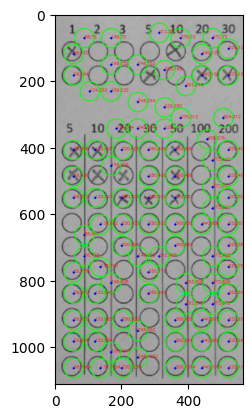

In [67]:
plt.imshow(newimg)